In [90]:
pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [91]:
!pip install graphviz


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [92]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
def f(x):
  return 3*x**2 - 4*x + 5

In [94]:
f(3.0)

20.0

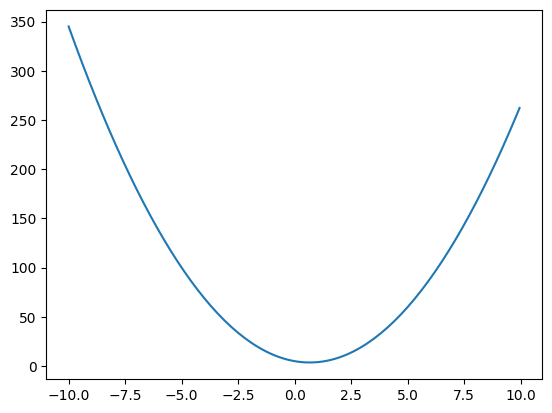

In [95]:
xs = np.arange(-10, 10, 0.15)
ys = f(xs)
plt.plot(xs, ys)

In [96]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [97]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c  
c += h
d2 = a*b + c 
# finding slope or derivative is how much function d changes, when a variable c changes by h, normalized by change h

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)   

d1 4.0
d2 4.0001
slope 0.9999999999976694


The derivative measures how much a function changes in response to a small change in its input.
### 📘 What is a Derivative?

The **derivative** measures how much a function's output changes in response to a small change in its input.

---

### 🔍 In other words:

It’s the **change in output divided by the change in input**:

The derivative is defined as:  
$\text{Derivative} = \frac{\Delta \text{Output}}{\Delta \text{Input}} = \frac{f(x + h) - f(x)}{h}$


This gives the **rate of change** of the function with respect to its input.

---

### ✅ Why normalize?

Without dividing by the input change, you wouldn’t know how sensitive the function is.  
By normalizing, you get the **change per unit input**, which is what a slope or derivative truly means.


In [98]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize a Value object that supports autodiff.

        Args:
            data (float): The numerical value of this node.
            _children (tuple): The input nodes (parents) that produced this value.
            _op (str): The operation that produced this node ('+', '*', etc.).
            label (str): Optional name for debugging or visualization.
        """
        self.data = data              # The actual scalar value
        self.grad = 0.0               # The gradient of the output w.r.t. this node
        self._backward = lambda: None  # Function to compute the local gradient (defined during operation)
        self._prev = set(_children)   # Set of input nodes (parents in the graph)
        self._op = _op                # Operation that produced this node
        self.label = label            # Label for display/graphing

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        """
        Overload the + operator to support Value + Value
        Creates a new Value node with proper history and backward function.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # Define the local backward pass for this addition
         # local derivative (1) * global derivative
        def _backward():
            # d(out)/d(self) = 1 for addition
             # accumulate += instead of =, to work in cases when same variable might appear twice in function
            self.grad += 1.0 * out.grad
            # d(out)/d(other) = 1
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Overload the * operator to support Value * Value
        Creates a new Value node with proper history and backward function.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        # Define the local backward pass for this multiplication
        #local derivative = dx2w2/dx2 = (dx2/dx2)*w2 + (dw2/dx2)*x2 = 1*w2 + 0 = w2 
        # local derivative * global derivative
        def _backward():
            # d(out)/d(self) = other.data 
            # accumulate += instead of =, to work in cases when same variable might appear twice in function
            self.grad += other.data * out.grad
            # d(out)/d(other) = self.data
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        """
        Apply tanh activation function and return new Value node.
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)  # tanh(x)
        out = Value(t, (self,), 'tanh')

        # Define the local backward pass for tanh
        def _backward():
            # d(tanh)/dx = 1 - tanh(x)^2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
          self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
    
        return out

    def backward(self):
        """
        Performs backpropagation to compute gradients from the output node
        back to all nodes that contributed to it (reverse-mode autodiff).
        """
        topo = []          # Topologically sorted list of all nodes in the graph
        visited = set()    # To avoid revisiting nodes

        # Build topological order via DFS
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:   # Visit all parent nodes (inputs)
                    build_topo(child)
                topo.append(v)          # Add node after its children

        build_topo(self)

        # Seed the output node's gradient to 1.0 (∂L/∂L = 1)
        self.grad = 1.0

        # Traverse in reverse topological order to propagate gradients
        for node in reversed(topo):
            node._backward()  # Apply the local chain rule


## Derivative Rules Used in Backpropagation

In reverse-mode automatic differentiation (used in neural networks and tools like PyTorch or micrograd), the backward pass relies on core calculus rules:

These rules are used to calculate how changes in inputs affect the final output, i.e., gradients.

| Rule          | Formula (Text)       | Gradient Contribution (Text)         |
|---------------|----------------------|--------------------------------------|
| Chain Rule    | f(g(x))              | dL/dx = dL/dz · dz/dx                |
| Sum Rule      | z = x + y            | dz/dx = 1, dz/dy = 1                 |
| Product Rule  | z = x * y            | dz/dx = y, dz/dy = x                 |


In [99]:
from graphviz import Digraph

def trace(root):
    """
    Recursively traces the computation graph from the output node `root`.

    Returns:
        nodes: A set of all Value nodes involved in computing `root`
        edges: A set of (parent, child) edges representing data dependencies
    """
    nodes, edges = set(), set()

    def build(v):
        # If the node hasn't been visited, add it
        if v not in nodes:
            nodes.add(v)
            # Recursively add all the parents (inputs to the operation)
            for child in v._prev:
                edges.add((child, v))  # Track edge from input to output
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    """
    Constructs a Graphviz Digraph that visualizes the computation graph
    starting from the `root` node (typically the final output like loss `L`).

    Each node shows:
        - label (e.g. 'a', 'b', 'L')
        - data value
        - gradient (computed via .backward())

    Arrows show the flow of computation from inputs to outputs.

    Returns:
        dot: A graphviz.Digraph object that can be rendered inline or exported
    """
    # Create a Graphviz graph object, oriented left to right
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # Get all nodes and their connections from the root
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))  # Unique ID for this node based on memory address

        # Create a graph node for this Value object, showing its label, data, and gradient
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape='record'
        )

        # If this node was produced by an operation, add a node for the operation
        if n._op:
            op_id = uid + n._op  # Unique ID for the op node
            dot.node(name=op_id, label=n._op)   # E.g. '*', '+'
            dot.edge(op_id, uid)                # Connect op → output node

    # Now connect input nodes to their respective operation nodes
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)  # input → operation

    return dot


In [100]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

## 🔄 Understanding `_children` in the Computation Graph

Each `Value` node in the graph tracks which other nodes were used to compute it using the `_children` attribute. This forms the **computation graph**, which is essential for backpropagation.

Below is a breakdown of what `_children` contains at each step.

---

### 📘 Code Example

```python
        # Input node
e = a * b                         # e = a * b = -6.0
d = e + c                         # d = e + c = 4.0
f = Value(-2.0, label='f')        # Input node
L = d * f                         # L = d * f = -8.0

a   b   c   f
 \ /     \   \
  *       +   *
   \     /     \
     e  c       d
       \       /
         \    /
           L

### 📦 `_children` Breakdown

| Variable | Operation | Computed From | `_children` |
|----------|-----------|----------------|-------------|
| `a`      | Input     | —              | `set()`     |
| `b`      | Input     | —              | `set()`     |
| `c`      | Input     | —              | `set()`     |
| `e`      | `a * b`   | `a`, `b`       | `{a, b}`    |
| `d`      | `e + c`   | `e`, `c`       | `{e, c}`    |
| `f`      | Input     | —              | `set()`     |
| `L`      | `d * f`   | `d`, `f`       | `{d, f}`    |


In [101]:
#conda install -c conda-forge graphviz


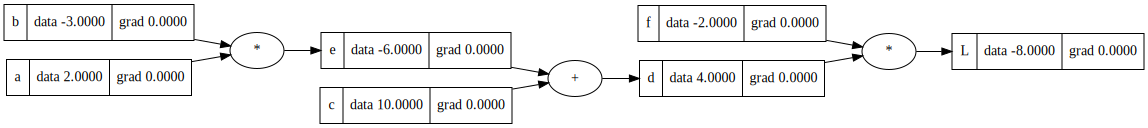

In [102]:
draw_dot(L)

In [103]:
L.backward() 

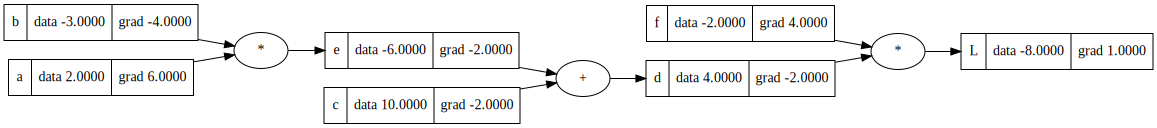

In [104]:
draw_dot(L)

## 🧠 Why Use `tanh` in Neural Networks and Autodiff?

The **hyperbolic tangent function (`tanh`)** is a commonly used non-linear activation function in neural networks and automatic differentiation systems like micrograd. https://en.wikipedia.org/wiki/Hyperbolic_functions

| Property                      | Explanation                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| **Output Range**              | \(-1\) to \(+1\) — centered at 0                                            |
| **S-shaped curve (non-linear)** | Introduces non-linearity — critical for learning complex patterns          |
| **Smooth and differentiable** | Needed for gradient-based optimization                                     |
| **Symmetric around origin**   | Unlike ReLU, `tanh` is zero-centered which can help in faster convergence  |


In [105]:
# === Inputs to the Neuron ===
x1 = Value(2.0, label='x1')   # First input feature
x2 = Value(0.0, label='x2')   # Second input feature

# === Weights for the inputs ===
w1 = Value(-3.0, label='w1')  # Weight for x1
w2 = Value(1.0, label='w2')   # Weight for x2

# === Bias Term ===
b = Value(6.8813735870195432, label='b')  # Bias of the neuron

# === Weighted Sum (Linear Combination) ===
x1w1 = x1 * w1               # x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2               # x2 * w2
x2w2.label = 'x2*w2'

# Sum the weighted inputs: x1*w1 + x2*w2
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add the bias: n = x1*w1 + x2*w2 + b
n = x1w1x2w2 + b
n.label = 'n'  # Neuron pre-activation value

# === Non-linearity (Activation Function) ===
o = n.tanh()    # Apply tanh activation: o = tanh(n)
o.label = 'o'   # Output of the neuron after activation


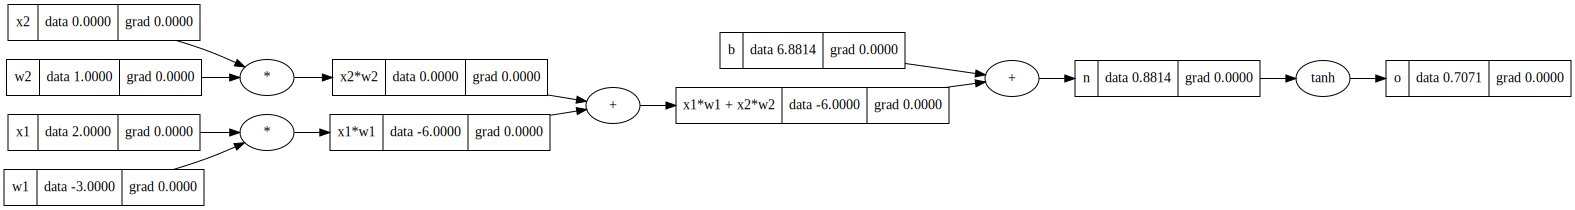

In [106]:
draw_dot(o)

In [107]:
o.backward()

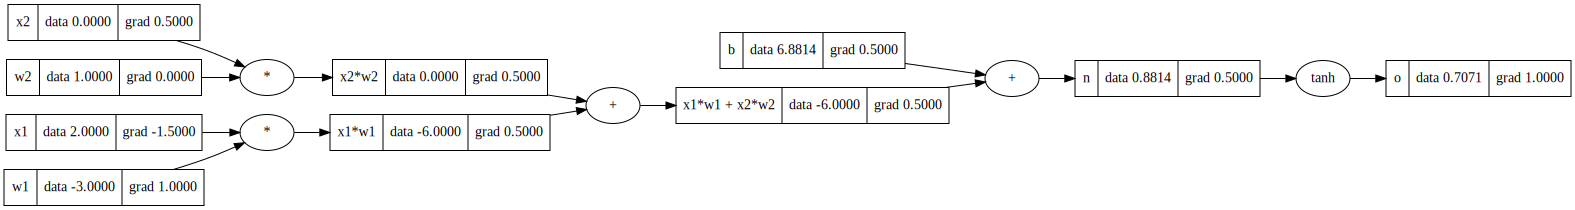

In [108]:
draw_dot(o)

Doing same thing using Pytorch

In [109]:
import torch

In [110]:
import torch

# Input values (treated as variables for autograd)
x1 = torch.Tensor([2.0]).double()                # Feature 1
x1.requires_grad = True                          # Track gradient w.r.t x1

x2 = torch.Tensor([0.0]).double()                # Feature 2 (zeroed out)
x2.requires_grad = True                          # Track gradient w.r.t x2

# Weights for each input
w1 = torch.Tensor([-3.0]).double()               # Weight for x1
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()                # Weight for x2
w2.requires_grad = True

# Bias term
b = torch.Tensor([6.8813735870195432]).double()  # Carefully chosen so tanh(0) = 0
b.requires_grad = True

# Linear combination: n = w1*x1 + w2*x2 + b
n = x1*w1 + x2*w2 + b

# Activation: apply tanh non-linearity
o = torch.tanh(n)

# Forward result
print(o.data.item())  # Print the scalar output of the neuron

# Backward pass: compute gradients via automatic differentiation
o.backward()

# Print the gradients of each input and weight
print('---')
print('x2', x2.grad.item())  # ∂o/∂x2
print('w2', w2.grad.item())  # ∂o/∂w2
print('x1', x1.grad.item())  # ∂o/∂x1
print('w1', w1.grad.item())  # ∂o/∂w1


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Building a Multi-Layer Perceptron (MLP) from scratch using:

Neurons, Layers, Activation functions (tanh)

## 🧠 Neuron

A **neuron** is the fundamental unit of a neural network. It:

- Takes multiple input values (called features).
- Multiplies each input by a learnable **weight**.
- Adds a **bias** term.
- Applies a **non-linear activation function** (e.g., `tanh` or `ReLU`).
- Produces a single scalar output.

The operation inside a neuron is: output = activation(w₁·x₁ + w₂·x₂ + ... + wₙ·xₙ + b)

## 🧱 Layer

A **layer** is a group of neurons operating in parallel. Each neuron:

- Receives the same input vector.
- Processes it with its own unique set of weights and bias.
- Outputs a scalar value.

The output of a layer is a vector: one scalar from each neuron.

---

## 🌐 MLP (Multi-Layer Perceptron)

A **multi-layer perceptron (MLP)** is a stack of layers, where:

- The first layer receives the raw input features.
- Each subsequent layer receives the output of the previous one.
- The final layer produces the model’s output (e.g., prediction or classification score).

The MLP can model complex, non-linear relationships thanks to:
- Stacked layers
- Non-linear activations like `tanh`

Example architecture:
- Input: 3 features (e.g., Age, Height, Weight)
- Hidden Layer 1: 4 neurons
- Hidden Layer 2: 4 neurons
- Output Layer: 1 neuron (e.g., binary classification)

---

## 🧮 Parameters

Each neuron has:
- A list of weights (one per input feature).
- A bias term.

The total number of parameters in the network =  
**(weights + biases)** in all neurons across all layers.

---

## 🔁 Training

To train the network:
- Provide example input-output pairs (training data).
- Use a loss function (e.g., mean squared error).
- Compute gradients of the loss with respect to each parameter (via backpropagation).
- Update weights using gradient descent to reduce the loss.

---

## 💡 Summary

| Concept        | Description                                      |
|----------------|--------------------------------------------------|
| Neuron         | Computes `tanh(w·x + b)`                         |
| Layer          | A group of neurons in parallel                   |
| MLP            | A sequence of layers for deep learning           |
| Parameters     | Weights and biases that are learned from data    |
| Training       | Adjusting parameters to minimize prediction error|

This structure forms the foundation of deep learning systems. Understanding it at this low level builds strong intuition for how frameworks like PyTorch and TensorFlow work internally.



| Class   | Role                                             |
|---------|--------------------------------------------------|
| Neuron  | Single computation unit: `tanh(w·x + b)`         |
| Layer   | Collection of neurons working in parallel        |
| MLP     | Full neural network: a stack of multiple layers  |


In [111]:
class Neuron:
  
  def __init__(self, nin):
    # Initialize weights and bias for this neuron
    # nin = number of input features
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  # list of weights, one per input
    self.b = Value(random.uniform(-1, 1))  # bias term

  def __call__(self, x):
    # Forward pass: compute the weighted sum + bias, then apply tanh activation
    # x = input vector (list of Value objects)
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)  # act = w·x + b
    out = act.tanh()  # apply non-linear activation
    return out

  def parameters(self):
    # Return all learnable parameters of the neuron (weights + bias)
    return self.w + [self.b]


class Layer:
  
  def __init__(self, nin, nout):
    # Create a layer with `nout` neurons, each receiving `nin` inputs
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    # Forward pass: pass the input `x` to each neuron in the layer
    outs = [n(x) for n in self.neurons]  # each neuron returns a Value
    return outs[0] if len(outs) == 1 else outs  # if 1 neuron, return scalar Value

  def parameters(self):
    # Collect parameters from all neurons in the layer
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  
  def __init__(self, nin, nouts):
    # Create a multi-layer perceptron
    # nin = number of input features
    # nouts = list of layer sizes (e.g., [4, 4, 1] means 2 hidden layers with 4 neurons and 1 output neuron)
    sz = [nin] + nouts  # build full shape list (input + all output sizes)
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]  # create all layers

  def __call__(self, x):
    # Forward pass through all layers
    for layer in self.layers:
      x = layer(x)  # each layer processes and returns new inputs for the next
    return x  # final output

  def parameters(self):
    # Collect all parameters from all layers
    return [p for layer in self.layers for p in layer.parameters()]


In [112]:
import random

## Single input, multiple features

In [113]:
# Define a single input vector with 3 features
x = [2.0, 3.0, -1.0]

# Create a Multi-Layer Perceptron:
# - Input layer: 3 features
# - Hidden layer 1: 4 neurons
# - Hidden layer 2: 4 neurons
# - Output layer: 1 neuron
n = MLP(3, [4, 4, 1])

# Perform a forward pass:
# The input vector `x` flows through the network layer by layer
# and returns the final output (a Value object, likely scalar)
n(x)


Value(data=-0.2783653851409171)

## Multiple inputs, multiple features

In [114]:
# Input dataset: each sub-list is an input vector with 3 features
xs = [
  [2.0, 3.0, -1.0],   # Input 1
  [3.0, -1.0, 0.5],   # Input 2
  [0.5, 1.0, 1.0],    # Input 3
  [1.0, 1.0, -1.0],   # Input 4
]

# Target values (labels) for supervised learning
# These are the expected outputs for each corresponding input
ys = [1.0, -1.0, -1.0, 1.0]  # Desired outputs for inputs above


In [115]:
for k in range(100):  # Run 20 training iterations (epochs)
  
  # Forward pass: compute model predictions for all inputs
  ypred = [n(x) for x in xs]  # Use the MLP `n` to predict output for each input x in xs

  # Compute loss: Mean Squared Error (sum of squared differences)
  loss = sum(((yout - Value(ygt))**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))
  # total loss over dataset
  
  # Backward pass: compute gradients of loss w.r.t. all parameters
  for p in n.parameters():
    p.grad = 0.0  # Reset gradients to zero before backward pass (required for correct accumulation)
  loss.backward()  # Auto-diff: compute gradients using chain rule
  
  # Update parameters using gradient descent
  for p in n.parameters():
    p.data += -0.1 * p.grad  # Gradient descent step (learning rate = 0.1)
  
  # Print training progress
  print(k, loss.data)  # Output: (iteration number, current loss value)


0 4.0541855964837445
1 2.889097305905471
2 1.8364106642650917
3 0.4873208931661194
4 0.05578519350474251
5 0.04687957389997175
6 0.04030034615625528
7 0.03525558722923204
8 0.03127387304355255
9 0.02805738895048475
10 0.02540905573374921
11 0.023193464232981232
12 0.02131463498701286
13 0.019702724587180448
14 0.018305751204074273
15 0.017084264210934837
16 0.016007807306659017
17 0.015052510433152654
18 0.014199412644505558
19 0.0134332703277493
20 0.012741694961841549
21 0.012114519132237218
22 0.01154332351473733
23 0.011021079240390579
24 0.010541874198816244
25 0.01010070123854904
26 0.009693292581867616
27 0.009315989142428007
28 0.00896563648323611
29 0.008639501308977138
30 0.008335203931287165
31 0.008050663264921838
32 0.00778405173294399
33 0.007533758066167598
34 0.007298356435828121
35 0.0070765807006127075
36 0.0068673028093935076
37 0.006669514600478488
38 0.006482312392251372
39 0.006304883879902237
40 0.006136496946786078
41 0.005976490072893357
42 0.005824264081545099

In [116]:
ypred

[Value(data=0.9789169829390815),
 Value(data=-0.9855603846500083),
 Value(data=-0.971403633902866),
 Value(data=0.9709999791435876)]